In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Input, LSTM

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/dl-lab-week5-data/BPD_Part_1_Victim_Based_Crime_Data.csv')
df.head(5)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Location 1,Total Incidents
0,11-12-2016,02:35:00,3B,300 SAINT PAUL PL,ROBBERY - STREET,O,NaN,111.0,CENTRAL,Downtown,"(39.2924100000, -76.6140800000)",1
1,11-12-2016,02:56:00,3CF,800 S BROADWAY,ROBBERY - COMMERCIAL,I,FIREARM,213.0,SOUTHEASTERN,Fells Point,"(39.2824200000, -76.5928800000)",1
2,11-12-2016,03:00:00,6D,1500 PENTWOOD RD,LARCENY FROM AUTO,O,NaN,413.0,NORTHEASTERN,Stonewood-Pentwood-Winston,"(39.3480500000, -76.5883400000)",1
3,11-12-2016,03:00:00,6D,6600 MILTON LN,LARCENY FROM AUTO,O,NaN,424.0,NORTHEASTERN,Westfield,"(39.3626300000, -76.5516100000)",1
4,11-12-2016,03:00:00,6E,300 W BALTIMORE ST,LARCENY,O,NaN,111.0,CENTRAL,Downtown,"(39.2893800000, -76.6197100000)",1


In [61]:
df['CrimeDate'] = pd.to_datetime(df['CrimeDate'], infer_datetime_format=True, errors='coerce')
df['CrimeCode'] = df['CrimeCode'].astype(str)

In [62]:
larceny_data = df[df['CrimeCode'].str.startswith('6')]
burglary_data = df[df['CrimeCode'].str.startswith('5')]

larceny_ts = larceny_data.groupby('CrimeDate').size().resample('D').sum().fillna(0)
burglary_ts = burglary_data.groupby('CrimeDate').size().resample('D').sum().fillna(0)

crime_ts = pd.DataFrame({'Larceny': larceny_ts, 'Burglary': burglary_ts})

In [63]:
crime_ts

,Larceny,Burglary
CrimeDate,,
2011-01-01,66,21
2011-01-02,40,19
2011-01-03,35,21
2011-01-04,41,12
2011-01-05,44,28
...,...,...
2016-11-08,40,19
2016-11-09,38,26
2016-11-10,40,24


In [64]:
#split the data into training (2014-2015) and testing (2016)
train_data = crime_ts['2014-01-01':'2015-12-31']
test_data = crime_ts['2016-01-01':'2016-12-31']

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_data_norm = scaler.fit_transform(train_data)

test_data_norm = scaler.fit_transform(test_data)

In [66]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

seq_len = 30
batch_size=32

train_gen = TimeseriesGenerator(train_data_norm,train_data_norm, length=seq_len,batch_size=batch_size)
test_gen = TimeseriesGenerator(test_data_norm,test_data_norm, length=seq_len,batch_size=batch_size)

In [67]:
model1 = Sequential([
    Input(shape=(seq_len,2)),
    SimpleRNN(64,return_sequences=True),
    SimpleRNN(64,return_sequences=True),
    SimpleRNN(64,return_sequences=True),
    SimpleRNN(64),
    Dense(2)
])

In [68]:
model1.summary()
model1.compile(optimizer = 'adam', loss='mse')

history1 = model1.fit(train_gen,epochs=20)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 30, 64)         │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 30, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 30, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,186 (114.01 KB)

 Trainable params: 29,186 (114.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7326
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1828
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1682
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1570
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1486
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1204
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1406
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1263
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1237
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1416
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1113
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0889
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0815
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0742
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0810
Epoc

In [69]:
model2 = Sequential([
    Input(shape=(seq_len,2)),
    LSTM(64,return_sequences=True),
    LSTM(64,return_sequences=True),
    LSTM(64,return_sequences=True),
    LSTM(64),
    Dense(2)
])

In [70]:
model2.summary()
model2.compile(optimizer = 'adam', loss='mse')

history2 = model2.fit(train_gen,epochs=20)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,354 (454.51 KB)

 Trainable params: 116,354 (454.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.6778
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.3212
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.3008
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.2774
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.2567
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.2501
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.2968
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.2373
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.2439
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.2486
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.2194
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.2264
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.2215
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.2682
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.2014
Epoc

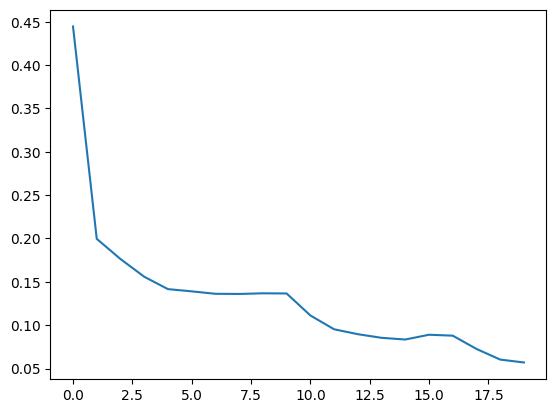

In [71]:
plt.plot(history1.history['loss'])

In [72]:
y_pred_1 = model1.predict(test_gen)
y_pred_2 = model2.predict(test_gen)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


In [75]:
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse

In [74]:
y_array = []
for i in range(len(test_gen)):
    x,y = test_gen[i]
    y_array.append(y)

y_test = np.concatenate(y_array)

In [80]:
perc_err1 = mape(y_test,y_pred_1)
rmse1 = np.sqrt(mse(y_test,y_pred_1))
perc_err2 = mape(y_test,y_pred_2)
rmse2 = np.sqrt(mse(y_test,y_pred_2))

print("perc_error m1: ", perc_err1)
print("rmse m1: ", rmse1)
print("perc_error m2: ", perc_err2)
print("rmse m2: ", rmse2)

perc_error m1:  0.45518353838086295
rmse m1:  0.6384496209894386
perc_error m2:  0.5012154162639164
rmse m2:  0.5712110935565524


In [81]:
y_test = test_data_norm[seq_len:]

In [82]:
perc_err1 = mape(y_test,y_pred_1)
rmse1 = np.sqrt(mse(y_test,y_pred_1))
perc_err2 = mape(y_test,y_pred_2)
rmse2 = np.sqrt(mse(y_test,y_pred_2))

print("perc_error m1: ", perc_err1)
print("rmse m1: ", rmse1)
print("perc_error m2: ", perc_err2)
print("rmse m2: ", rmse2)

perc_error m1:  0.45518353838086295
rmse m1:  0.6384496209894386
perc_error m2:  0.5012154162639164
rmse m2:  0.5712110935565524
